In [2]:
import keras
from keras import layers
import numpy as np
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [32]:
latent_dim = 2
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
dense_13 (Dense)             (None, 32768)             98304     
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

In [33]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)

x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_62 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

In [34]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)

gan.summary()

gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 2)                 0         
_________________________________________________________________
model_19 (Model)             (None, 32, 32, 3)         5281539   
_________________________________________________________________
model_20 (Model)             (None, 1)                 790913    
Total params: 6,072,452
Trainable params: 5,281,539
Non-trainable params: 790,913
_________________________________________________________________


In [35]:
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 选择青蛙图像（类别编号为 6）
x_train = x_train[y_train.flatten() == 6]

# 数据标准化
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)
).astype('float32') / 255.

iterations = 5000
batch_size = 25
save_dir = '../images/gan_images/'

start = 0
for step in range(iterations):
    # 再采样空间中随机采样点
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 将这些点解码为虚假图像
    generated_images = generator.predict(random_latent_vectors)

    # 将这些虚假图像与真实图像混合在一起
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 将真实标签和虚假标签区分开来
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])

    # 在标签中添加随机噪声
    labels += 0.05 * np.random.random(labels.shape)

    # 训练判别器
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # 在潜在空间中随机采样点
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # 将所有标签合并成真实标签
    misleading_targets = np.zeros((batch_size, 1))

    # 通过gan模型来训练生成器（此时冻结判别器）
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0

    if step % 100 == 0:
        if step % 1000 == 0:
            gan.save_weights('../models/gan/gan_%d.h5' % step)
        print('Step %s: Discriminator loss: %s; Adversarial loss: %s' % (step, d_loss, a_loss))

        # 保存一张生成图像
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # 保存一张真实图像，用于对比
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

Step 0: Discriminator loss: 0.6787876; Adversarial loss: 0.5873865


/Users/Bureaux/opt/miniconda3/envs/AI-base/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 100: Discriminator loss: 0.7132107; Adversarial loss: 0.7517303
Step 200: Discriminator loss: 0.69641393; Adversarial loss: 0.8825026
Step 300: Discriminator loss: 0.7103958; Adversarial loss: 0.7863331
Step 400: Discriminator loss: 0.68717873; Adversarial loss: 0.7755039
Step 500: Discriminator loss: 0.7116812; Adversarial loss: 0.75652206
Step 600: Discriminator loss: 0.70792127; Adversarial loss: 0.78819925
Step 700: Discriminator loss: 0.7011673; Adversarial loss: 0.7816236
Step 800: Discriminator loss: 0.6955221; Adversarial loss: 0.77717394
Step 900: Discriminator loss: 0.69277817; Adversarial loss: 0.7355576
Step 1000: Discriminator loss: 1.5358381; Adversarial loss: 4.005789
Step 1100: Discriminator loss: 0.68990535; Adversarial loss: 0.7592878
Step 1200: Discriminator loss: 0.69697535; Adversarial loss: 0.7639634
Step 1300: Discriminator loss: 0.7009123; Adversarial loss: 0.7859696
Step 1400: Discriminator loss: 0.7008073; Adversarial loss: 0.81226134
Step 1500: Discrimin

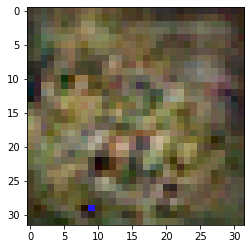

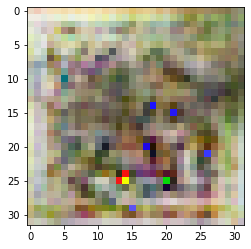

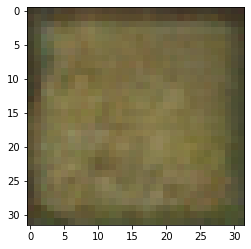

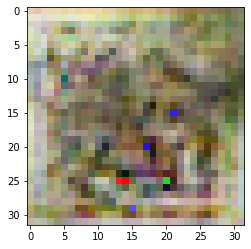

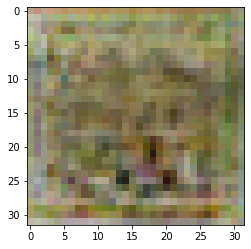

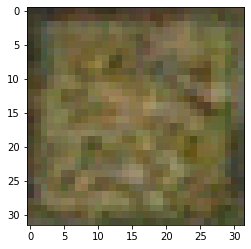

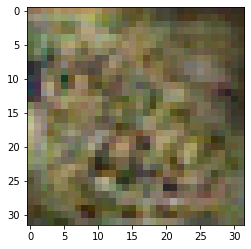

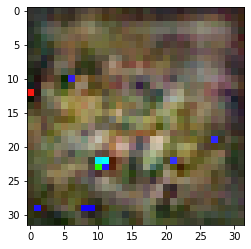

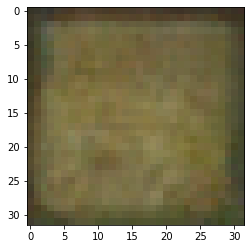

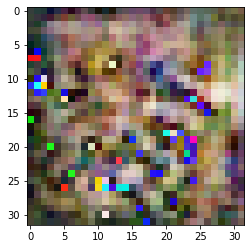

In [52]:
# sample random points in the latent space（在潜在空间中采样随机点）
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images（将这些点解码为虚假图像）
gan.load_weights("../models/gan/gan_3000.h5")
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()